El objetivo de este notebook es hacer una implementación rápida de un Decision Tree y ganar intuición sobre la forma de tomar las decisiones.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


In [ ]:
import numpy as np
import joblib
import sys
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [ ]:
# Importar los datos
features = joblib.load("/content/drive/My Drive/repo_tesis/data/FEATURES_W200_I50.joblib")
label = joblib.load("/content/drive/My Drive/repo_tesis/data/label_W200_I50.joblib")

features_array = np.array(features)
label_array = np.array(label)

In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(2) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

print(folds_ind)
print(sujetos_array)

/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest
[array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844]), array([57845, 57846, 57847, ..., 64523, 64524, 64525])]
[1, 0, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
%cd "/content/drive/My Drive/repo_tesis/src/ronda_experimentos_1/particiones_1subTest"

full_pipeline = Pipeline([
    ('dt_classifier', DecisionTreeClassifier(max_depth=10))
])


grilla_max_depth = [15]

metricas_grilla = []
modelos_grilla = []

# busqueda de hiperparametros mediante validacion cruzada
for k in range(len(grilla_max_depth)):
  metricas = []
  modelos = []
  for i in range(0, 1): # aca decido qué sujeto va para test
    # Importo particiones
    folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl') # lista de listas. en cada elemento tengo la lista de indices de un fold
    sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(i+1) + '.pkl')   # lista con todos los sujetos, donde el primero corresponde al de test

    # por el criterio elegido, se que el primer fold es para test, asi que lo saco
    fold_test = folds_ind[0]

    # ahora lo quito para no armar entrevero
    folds_ind = folds_ind[1:]
    sujetos_CV = sujetos_array[1:]   # me quedo solo con los sujetos que voy usar para hacer CV
    # voy a hacer cross validation a mano
    # defino los folds que tengo, voy a ir dejando en validacion de a 1
    num_folds = np.arange(0, 9)   # no importa que no coincida con el sujeto, es solo para recorrer cada fold, al final me puedo fijar a qué sujeto pertenecía

    precision_train = []
    accuracy_train = []
    recall_train = []
    precision_val = []
    accuracy_val = []
    recall_val = []

    for ind_fold_val in num_folds:  # voy tomando los folds de validacion en orden segun folds_ind, es decir sujetos_array
      folds_ind_train = folds_ind.copy()
      folds_ind_train.pop(ind_fold_val)
      fold_ind_val = folds_ind[ind_fold_val]

      # concateno los arrays en uno solo
      folds_ind_train_array = np.concatenate(folds_ind_train)

      # aplanar el array resultante
      folds_ind_train_array = folds_ind_train_array.ravel()

      # concateno los arrays en uno solo
      fold_ind_val_array = np.array(fold_ind_val)

      # Defino X_train, y_train, X_val, y_val
      X_train = features_array[folds_ind_train_array, :]
      y_train = label_array[folds_ind_train_array, 1]

      X_val = features_array[fold_ind_val_array, :]
      y_val = label_array[fold_ind_val_array, 1]

      # ajusto el modelo con los datos de entrenamiento
      modelo = DecisionTreeClassifier(max_depth=grilla_max_depth[k])
      modelo.fit(X_train, y_train)

      # calculo las predicciones sobre los datos de train y val
      y_pred_train = modelo.predict(X_train)
      y_pred_val = modelo.predict(X_val)

      # calculo metricas sobre conjunto de train y val
      precision_train.append(precision_score(y_train, y_pred_train, average='weighted'))
      precision_val.append(precision_score(y_val, y_pred_val, average='weighted'))
      accuracy_train.append(accuracy_score(y_train, y_pred_train))
      accuracy_val.append(accuracy_score(y_val, y_pred_val))
      recall_train.append(recall_score(y_train, y_pred_train, average='weighted'))
      recall_val.append(recall_score(y_val, y_pred_val, average='weighted'))

        # Crear DataFrame
    data = {'Fold_val': sujetos_CV,
            'precision_train': precision_train,
            'precision_val': precision_val,
            'accuracy_train': accuracy_train,
            'accuracy_val': accuracy_val,
            'recall_train': recall_train,
            'recall_val': recall_val}

    df = pd.DataFrame(data)

    metricas.append(df)
    modelos.append(modelos)
  metricas_grilla.append(metricas)
  modelos_grilla.append(modelos)

joblib.dump(metricas_grilla, 'metricas_grilla_dt.pkl')
joblib.dump(modelos_grilla, 'modelos_grilla_dt.pkl')

'''
por cada sujeto que mando a test, tengo un dataFrame de metricas, donde cada fila corresponde a una iteracion de CV (usando un fold
de validacion distinto)
'''


In [ ]:
df.head()

,Fold_val,precision_train,precision_val,accuracy_train,accuracy_val,recall_train,recall_val
0,1,0.729994,0.273534,0.714855,0.271979,0.714855,0.271979
1,2,0.731207,0.276305,0.716428,0.272825,0.716428,0.272825
2,3,0.708365,0.299790,0.686608,0.286331,0.686608,0.286331
3,4,0.742167,0.298077,0.718451,0.277179,0.718451,0.277179
4,5,0.741865,0.177389,0.721786,0.170036,0.721786,0.170036


In [ ]:
folds_ind = joblib.load('folds_W200_I50_sujetoTest_' + str(1) + '.pkl')
sujetos_array = joblib.load('arraySujetos_folds_W200_I50_sujetoTest_' + str(2) + '.pkl')

print(folds_ind)

[array([], dtype=int64), array([   0,    1,    2, ..., 5555, 5556, 5557]), array([ 5558,  5559,  5560, ..., 12118, 12119, 12120]), array([12121, 12122, 12123, ..., 17671, 17672, 17673]), array([17674, 17675, 17676, ..., 24621, 24622, 24623]), array([24624, 24625, 24626, ..., 31115, 31116, 31117]), array([31118, 31119, 31120, ..., 37990, 37991, 37992]), array([37993, 37994, 37995, ..., 44782, 44783, 44784]), array([44785, 44786, 44787, ..., 51319, 51320, 51321]), array([51322, 51323, 51324, ..., 57842, 57843, 57844])]


[0.9803507720639316, 0.9810595305604514, 0.9720765826319885, 0.9750634630693622, 0.9797504621486932, 0.9803027936134808, 0.9770291971985807, 0.9791968459797772, 0.9755812753441471]


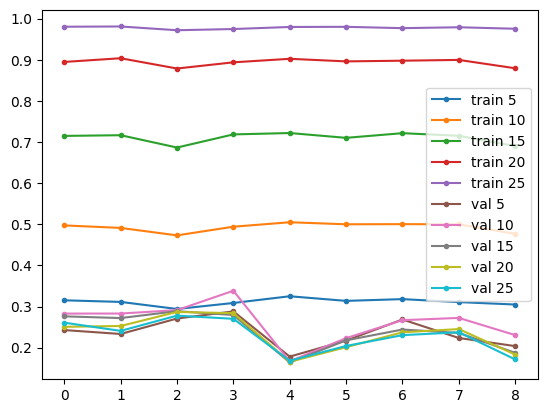

In [ ]:
# visualizacion de las metricas obtenidas
print(metricas[0][0])

# Grafico de las metricas
plt.figure()
plt.plot(metricas_grilla[0][0][1], '.-')
plt.plot(metricas_grilla[1][0][1], '.-')
plt.plot(metricas_grilla[2][0][1], '.-')
plt.plot(metricas_grilla[3][0][1], '.-')
plt.plot(metricas_grilla[4][0][1], '.-')

plt.plot(metricas_grilla[0][0][4], '.-')
plt.plot(metricas_grilla[1][0][4], '.-')
plt.plot(metricas_grilla[2][0][4], '.-')
plt.plot(metricas_grilla[3][0][4], '.-')
plt.plot(metricas_grilla[4][0][4], '.-')

plt.legend(['train 5', 'train 10', 'train 15', 'train 20', 'train 25','val 5', 'val 10', 'val 15', 'val 20', 'val 25'])